In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)


## Read data

In [59]:
import os
seq_len = 64
im_size = 28

In [107]:
def read_img_sequences(path_to_folder, size = 200):
    curr_size = 0
    data = []
    labels = []
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * seq_len
        sequence_labels = [None] * seq_len
        for img_path in os.listdir(full_sequence_folder):

            ind, label = img_path[:-3].split('_')
            ind = int(ind)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            img = torch.load(full_path_to_img).view(-1, im_size*im_size).detach().cpu().numpy()
            sequence_img[ind] = img
            sequence_labels[ind] = label
            
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [108]:
anomaly_data, anomaly_labels = read_img_sequences('img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('img_ts_normal/', size = 400)

In [128]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [129]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [130]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n+1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n+1).to(device) * p_slice * cumprod  + (w + 1)*torch.prod(prod[1:])*(1 - p_slice[-1])
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [164]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):

            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = alpha*loss_delay_detection(outputs[i, ind[0]: ind[0] + w], w) + (1 - alpha)*loss_false_alarms(outputs[i, :ind[0]])
        loss = torch.mean(loss)
        return loss

## Model

In [165]:
# input data parameters
input_size = im_size*im_size
output_size = seq_len

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 32

In [166]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)
    
    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [134]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [135]:
device = torch.device("cuda:1")

In [136]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [184]:
model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#loss_function = CustomLoss()
loss_function = torch.nn.BCELoss()
model.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [185]:
epochs = 100
print_every = 50
valid_loss_min = np.Inf

loss_list = []
acc_list = []
counter = 0
model.train()

out_list = []
labels_list = []

for i in range(epochs):
    
    for inputs, labels in tqdm(train_loader):
        if inputs.shape[0] < batch_size:
            break
            
        counter += 1
        h = model.init_hidden(batch_size)
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)  
        
        # shape of lstm_in: [seq_len, batch_size, input_size]
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).

        output, h = model(inputs, h)
        loss = loss_function(output.squeeze(), labels.float())
        loss_list += [loss.cpu().clone().detach()]
        accuracy = (output > 0.5).long() == labels
        acc_list += [accuracy.cpu().detach().float().mean()]
        out_list.append(output.cpu().detach().float())
        labels_list.append(labels.cpu().detach().float())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if counter%print_every == 0:
            val_losses = []
            val_outputs = []
            model.eval()
            for val_inputs, val_labels in val_loader:
                if val_inputs.shape[0] < batch_size:
                    break
                val_h = model.init_hidden(batch_size)
                val_h = tuple([each.data for each in val_h])
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_out, val_h = model(val_inputs, val_h)
                val_loss = loss_function(val_out.squeeze(), val_labels.float())
                val_losses.append(val_loss.item())
                val_outputs += [val_out.cpu().clone().detach()]
                
            val_outputs_one = torch.cat(val_outputs, 0)
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
        





Epoch: 5/100... Step: 50... Loss: 0.056106... Val Loss: 0.041949


Epoch: 10/100... Step: 100... Loss: 0.031299... Val Loss: 0.028031




Epoch: 14/100... Step: 150... Loss: 0.014951... Val Loss: 0.028486


Epoch: 19/100... Step: 200... Loss: 0.034920... Val Loss: 0.026679


Epoch: 23/100... Step: 250... Loss: 0.018797... Val Loss: 0.031394






Epoch: 28/100... Step: 300... Loss: 0.006312... Val Loss: 0.035921


Epoch: 32/100... Step: 350... Loss: 0.003950... Val Loss: 0.030002




Epoch: 37/100... Step: 400... Loss: 0.005367... Val Loss: 0.030122








Epoch: 41/100... Step: 450... Loss: 0.003275... Val Loss: 0.046017


Epoch: 46/100... Step: 500... Loss: 0.003669... Val Loss: 0.039560




Epoch: 50/100... Step: 550... Loss: 0.005456... Val Loss: 0.050434


Epoch: 55/100... Step: 600... Loss: 0.004191... Val Loss: 0.045280





Epoch: 60/100... Step: 650... Loss: 0.001829... Val Loss: 0.068506


Epoch: 64/100... Step: 700... Loss: 0.002816... Val Loss: 0.043740


























Epoch: 69/100... Step: 750... Loss: 0.000684... Val Loss: 0.058916


Epoch: 73/100... Step: 800... Loss: 0.003132... Val Loss: 0.047944





Epoch: 78/100... Step: 850... Loss: 0.004450... Val Loss: 0.076153


Epoch: 82/100... Step: 900... Loss: 0.002609... Val Loss: 0.071019





Epoch: 87/100... Step: 950... Loss: 0.006560... Val Loss: 0.042981


Epoch: 91/100... Step: 1000... Loss: 0.001089... Val Loss: 0.031605





Epoch: 96/100... Step: 1050... Loss: 0.001836... Val Loss: 0.066877


Epoch: 100/100... Step: 1100... Loss: 0.004392... Val Loss: 0.058973


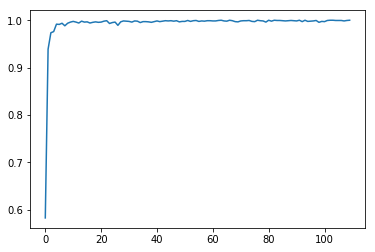

In [189]:
plt.plot(acc_list[::10])

In [190]:
def evaluate_metrics(y_true, y_pred):
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    ind_real = torch.where(y_true != y_true[0])[0]
    ind_detect = torch.where((y_pred > 0.5).long() != y_true[0])[0]

    if len(ind_real) > 0:
        real_change_ind = ind_real[0]

        if len(ind_detect) > 0:
            ind_sub_detect = torch.where(ind_detect > real_change_ind)[0]

            if len(ind_sub_detect) == len(ind_detect):
                detect_change_ind = ind_detect[0]
                delay = (detect_change_ind - real_change_ind).cpu().detach().numpy()
            else:
                false_positive += 1
        else:
            false_negative += 1

    else:
        if len(ind_detect) > 0:
            false_positive += 1
        else:
            true_negative += 1
    
    return false_positive, false_negative, delay

In [191]:
test_loss_list = []
test_acc_list = []

fp_list = []
fn_list = []
delay_list = []


model.eval()
for test_inputs, test_labels in test_loader:
    
    if test_inputs.shape[0] < batch_size:
        break
    test_h = model.init_hidden(batch_size)
    test_h = tuple([each.data for each in test_h])
    
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    test_output, test_h = model(test_inputs, test_h)
    test_loss = loss_function(test_output.squeeze(), test_labels.float())
    test_loss_list += [test_loss.cpu().clone().detach()]
    
    for i in range(0, batch_size):
        curr_output = test_output[i]
        curr_labels = test_labels[i]
        
        curr_fp, curr_fn, curr_delay = evaluate_metrics(curr_labels, curr_output)
        
        fp_list.append(curr_fp)
        fn_list.append(curr_fn)
        delay_list.append(curr_delay)
    
    accuracy = (test_output > 0.5).long() == test_labels
    test_acc_list += [accuracy.cpu().detach().float().mean()]

    
print("Test loss: {:.3f}".format(np.mean(test_loss_list)))
print("Test accuracy: {:.3f}%".format(np.mean(test_acc_list)))
print("Test delay: {:.2f}".format(np.mean(delay_list)))
print("Test FP: ", (np.sum(fp_list)))
print("Test FN: ", (np.sum(fn_list)))

Test loss: 0.038
Test accuracy: 0.993%
Test delay: 0.35
Test FP:  16
Test FN:  0


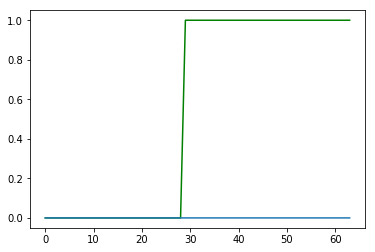

In [194]:
ind = 3
plt.plot(test_labels[ind].cpu().detach().numpy(), color='green')
plt.plot(test_output[ind].cpu().detach().numpy())